In [46]:
from utils import *
import numpy as np
import sys, os, random
import statistics


# from compare_locations import compare_locations

datadir = "../../data.upb/precis/02-precis-redmi-pixel4a/"
pix_etaje = [ "0-pixel-04-06-2021_19-34-41.json"]  
red_etaje = [ "0-redmi-04-06-2021_19-33-47.json"]




In [30]:
datadir = "../../data.upb/precis/01-precis-redmi-pixel4a/nowl/"
pix_etaje = [
"0-pixel-04-03-2021_15-32-38.json",
"1-pixel-25-02-2021_21-16-46.json",
"2-pixel-25-02-2021_16-27-45.json",
"3-pixel-04-03-2021_16-18-50.json",
"4-pixel-04-03-2021_16-43-50.json",
"5-pixel-04-03-2021_17-11-32.json",
"6-pixel-17-03-2021_12-52-29.json",
"7-pixel-17-03-2021_13-14-36.json"]

red_etaje = [
"0-redmi-04-03-2021_15-31-12.json",
"1-redmi-25-02-2021_21-16-10.json",
"2-redmi-25-02-2021_16-27-08.json",
"3-redmi-04-03-2021_16-18-52.json",
"4-redmi-04-03-2021_16-43-45.json",
"5-redmi-04-03-2021_17-11-30.json",
"6-redmi-17-03-2021_12-52-29.json",
"7-redmi-17-03-2021_13-14-39.json"]

In [31]:
import numpy as np
from scipy.spatial.distance import *
from scipy.stats import ks_2samp, chisquare
import copy 

def real_braycurtis(u, v, ex):
    """
    Compute the Bray-Curtis distance between two 1-D arrays.
    Bray-Curtis distance is defined as
    .. math::
       \\sum{|u_i-v_i|} / \\sum{|u_i+v_i|}
    The Bray-Curtis distance is in the range [0, 1] if all coordinates are
    positive, and is undefined if the inputs are of length zero.
    """
    l1_diff = abs(u - v)
    l1_sum = abs(u + v)
    
    return (abs(ex) + l1_diff.sum()) / (abs(ex) + l1_sum.sum())


def precalculate(c): # c is a collection
    """ creates new fields to speed up distance comparisons 
          c.ufingerprint['wifirssi'][mac] = average dBm 
    """
    ufingerprint = {}
    ufingerprint['wifirssi'] = {}
    for f in c['fingerprints']:
        if not "wifi" in f.keys():
            continue
        for mac in f["wifi"].keys():
            avg_pow = np.average(f["wifi"][mac]['rssi']) # each fingerprint (direction) counts the same
            if not mac in ufingerprint["wifirssi"].keys():
                ufingerprint["wifirssi"][mac] = [avg_pow] 
            else:
                ufingerprint["wifirssi"][mac].append(avg_pow)
    for mac in ufingerprint["wifirssi"].keys():
        ufingerprint["wifirssi"][mac] = \
            np.average(adjust_rssi(ufingerprint["wifirssi"][mac])) #each fingerprint (direction) counts the same
    c['ufingerprint'] = ufingerprint
                
def merge_wifi_fingerprints1(flist):
    if len(flist) == 1:
        return flist[0]
    fingerprint = copy.deepcopy(flist[0])
    for f2 in copy.deepcopy(flist[1:]):
        if not "wifi" in f2.keys():
            continue
        for mac in f2["wifi"].keys():
            if not mac in fingerprint["wifi"].keys():
                fingerprint["wifi"][mac] = f2["wifi"][mac]
            else:
                fingerprint["wifi"][mac]['rssi'].extend(f2["wifi"][mac]['rssi'])
            fingerprint["wifi"][mac]['rssi'].sort()    
    return fingerprint

def compare_locations(c1, c2, simil_method = braycurtis,  selection = 'Average', dif = True):
    # precalculated with average, adjust_rssi  
    wifi1 = c1['ufingerprint']['wifirssi']
    wifi2 = c2['ufingerprint']['wifirssi']      
    
    common_aps = list(set(wifi1.keys()) & set(wifi2.keys()))
    # No APs in common -> similarity = 1
    if not common_aps:
        return 1.0

    if len(common_aps) * 5 <= len(wifi1.keys()) or len(common_aps) < 3:
        return 1.0

    aps1 = set(wifi1.keys()) - set(common_aps)
    aps2 = set(wifi2.keys()) - set(common_aps)
    rssi1 = np.empty(len(common_aps) + len(aps1) + len(aps2), dtype=float)
    rssi2 = np.empty(len(common_aps) + len(aps1) + len(aps2), dtype=float)
    nap = 0   #  
    
    if selection == 'First':
        for ap in common_aps:
            rssi1.append(wifi1[ap]['rssi'][0])
            rssi2.append(wifi2[ap]['rssi'][0])

        # Make an average of all RSSI values
    if selection == 'Average':
        for ap in common_aps:
            rssi1[nap] = wifi1[ap]
            rssi2[nap] = wifi2[ap]
            nap = nap + 1
            
    if selection == 'Median':
        for ap in common_aps:
            rssi1.append(np.median(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.median(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Mean':
        for ap in common_aps:
            rssi1.append(np.mean(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.mean(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Std':
        for ap in common_aps:
            rssi1.append(np.std(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.std(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Max':
        for ap in common_aps:
            rssi1.append(np.max(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.max(adjust_rssi(wifi2[ap]['rssi'])))
            
    if selection == 'KS':
        for ap in common_aps:
            _, p = ks_2samp(wifi1[ap]['rssi'], wifi2[ap]['rssi'])
            rssi1.append(p)
            rssi2.append(1.0)

    if (dif == True) and (selection != 'KS'):
        if len(rssi1) > nap:
            rssi1[nap] = rssi1[0]
            rssi2[nap] = rssi2[0]
        rssi1 = np.diff(rssi1, append=rssi1[0])
        rssi2 = np.diff(rssi2, append=rssi1[0])   

   
    """
    p1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), wifi1.keys())))
    p2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), wifi2.keys())))
    pc1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), common_aps)))
    pc2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), common_aps)))
    po1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), aps1)))
    po2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), aps2)))        
    iou = len(common_aps) / \
        (len(aps1) + len(aps2) + len(common_aps))
    """
        
    for ap in aps1:
        rssi1[nap] = 1.0*wifi1[ap]
        rssi2[nap] = adjust_rssi(-95.0)[0]
        nap = nap + 1
    for ap in aps2:
        rssi2[nap] = 1.0*wifi2[ap]
        rssi1[nap] = adjust_rssi(-95.0)[0]
        nap = nap + 1
        
    return simil_method(rssi1, rssi2)
    #return rssi1, rssi2




In [48]:
retaje = []
for e in red_etaje: 
    json_file = os.path.join(datadir, e)
    etaj = load_dataset_json(json_file)
    for c in etaj:
        precalculate(c)
    retaje.append(etaj)

petaje = []
for e in pix_etaje: 
    json_file = os.path.join(datadir, e)
    etaj = load_dataset_json(json_file)
    for c in etaj:
        precalculate(c)
    petaje.append(etaj)
    

In [147]:
# compute similarities using neighbors < 7m 
# 

before = datetime.datetime.now()
etaje = retaje 
TP, FP, FN, R = 0, 0, 0, 0  
npct = 400 
fpd, posd = [], []
bd = []
bd_min = []
minra = []

for e in range(0,len(etaje)):
    bc_matrix = np.zeros(shape=(len(etaje[e]), len(etaje[e])))
    eu_dist_matrix = np.zeros(shape=(len(etaje[e]), len(etaje[e])))
    print(len(etaje[e]))
    mindisim = 1
    mindist = 100000
    for q in range(0,len(etaje[e])):
        for p in range(q+1,len(etaje[e])):
            if p > q:
                eu_dist = euclidean([etaje[e][q]['x'], etaje[e][q]['y'], etaje[e][q]['z']], 
                                        [etaje[e][p]['x'], etaje[e][p]['y'], etaje[e][p]['z']]) 
                if eu_dist > 20.0: 
                    continue
                bc = compare_locations(etaje[e][q], etaje[e][p], selection = 'Average', \
                                              dif=True, simil_method=braycurtis)
                #cor = compare_locations(etaje[e][q], etaje[e][p], selection = 'Average', \
                #                              dif=True, simil_method=cosine)
                R, thr = 2.0, 0.29
                if bc < thr: 
                    if eu_dist < R:
                        TP = TP + 1 
                    else:
                        FP = FP + 1
                        fpd.append(eu_dist)
                    posd.append(eu_dist)    
                else:
                    if eu_dist < R:
                        FN = FN + 1
                           
                #print(p,q)
                bc_matrix[p][q] = bc
                bc_matrix[q][p] = bc
                eu_dist_matrix[p][q] = eu_dist
                eu_dist_matrix[q][p] = eu_dist
                                        
                bd.append([ q, p, eu_dist, bc])
                bd_min.append([q, p, round(eu_dist, 1), round(bc, 3)])
after = datetime.datetime.now()

print(f"R= {R} bc={thr} Precision= {TP*1.0/(TP+FP):.2f} Recall= {TP*1.0/(TP+FN):.2f} \
Pdist = {np.percentile(posd, [50, 95, 99])} ")
m = np.polyfit([r[2] for r in bd] , [r[3] for r in bd], 1)
print(f"Slope = {m[0]:.2f}")

85
R= 2.0 bc=0.29 Precision= 0.64 Recall= 0.96 Pdist = [1.817      3.6384     4.24893162] 
Slope = 0.08


Slope = [0.00041833 0.06787149 0.09580204]


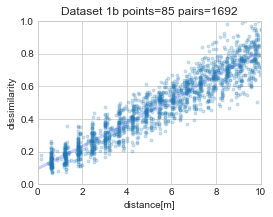

In [86]:
plt.style.use("seaborn-whitegrid")   
fig =  plt.figure(figsize=(4, 3))     # bc, realbc, iou   
m = np.polyfit([r[2] for r in bd] , [r[3] for r in bd], 2)
print(f"Slope = {m}")
predict = np.poly1d(m)
x_lin_reg = np.arange(0.0, 10.0, 0.1)
y_lin_reg = predict(x_lin_reg)
plt.plot(x_lin_reg, y_lin_reg, c = 'b', alpha=0.2, linewidth=3)

plt.plot([r[2] for r in bd] , [r[3] for r in bd], ".", label='bc', alpha=0.2)
plt.xlabel('distance[m]')
plt.ylabel('dissimilarity')
plt.grid(True)
plt.title(f"Dataset 1b points={len(etaje[0])} pairs={len(bd)}")
#plt.xticks(range(0, 20, 2))
plt.ylim(0, 1.0)
plt.xlim(0, 10.0)
#plt.yticks(np.arange(0, 1, 0.1))
#plt.legend(loc="upper left",shadow=True, fancybox=True)
plt.show()
fig.savefig(f"braycurtis-vs-distance-ds1b.svg", bbox_inches='tight')

In [35]:
def get_calculated_distance_from_dissimilarity(dissim):
    m = np.polyfit([r[2] for r in bd] , [r[3] for r in bd], 2)
    predict = np.poly1d(m)
    x_lin_reg = np.arange(0.0, 10.0, 0.1)
    y_lin_reg = predict(x_lin_reg)
    
    y_lin_reg = np.trunc(y_lin_reg*10**3)/(10**3)
    x_lin_reg = np.trunc(x_lin_reg*10**1)/(10**1)
    
    for d in range(0,len(y_lin_reg)):
        if y_lin_reg[d] == dissim:
            return x_lin_reg[d]

def get_calculated_dissimilarity_from_distance(distance):
    m = np.polyfit([r[2] for r in bd] , [r[3] for r in bd], 2)
    predict = np.poly1d(m)
    x_lin_reg = np.arange(0.0, 10.0, 0.1)
    y_lin_reg = predict(x_lin_reg)
    
    y_lin_reg = np.trunc(y_lin_reg*10**3)/(10**3)
    x_lin_reg = np.trunc(x_lin_reg*10**1)/(10**1)
    
    for d in range(0,len(x_lin_reg)):
        if x_lin_reg[d] == distance:
            return y_lin_reg[d]

def get_real_dissimilarities_from_distance(distance):
    dissim = []
    for r in bd_min:
        if round(r[2],1) == distance:
            dissim.append(r[3])
            
    return dissim

def get_real_distances_from_dissimilarity(dissim):
    distances = []
    for r in bd:
        if round(r[3],3) == dissim:
            distances.append(r[2])
            
    return distances

    #for r in bd:
    #    print(r[2], r[3])

In [36]:
#dissimilarity_function(0.1)
#print("Real Dissim: ", get_dissimilarities_from_distance(2.0))
#print("Our Calculated Dissim: ", my_dissimilarity_function(2.0))

real_dissim = get_real_dissimilarities_from_distance(9.8)
real_dist = get_real_distances_from_dissimilarity(0.25)
print("REAL dissim: ", real_dissim)
print("REAL distances: ", real_dist)

print("Calculated dissim: ", get_calculated_dissimilarity_from_distance(9.8))
print("Calculated distance: ", get_calculated_distance_from_dissimilarity(0.119))




print("Numpy Standard deviation: ", np.std(real_dissim))
print("Numpy Variance: ", np.var(real_dissim))
print("Mean: ", sum(real_dissim)/len(real_dissim))
print("Statistics variance: ", statistics.variance(real_dissim))
print("Statistics pvariance: ", statistics.pvariance(real_dissim))
print("Statistics Standard deviation: ", statistics.pstdev(real_dissim))
print("Statistics Standard deviation: ", statistics.stdev(real_dissim))



#print(bd)

REAL dissim:  [1.028, 0.956, 0.785, 0.922, 0.797, 0.808, 0.859, 0.536, 0.845, 1.254, 1.185, 0.641, 0.815, 0.845, 0.8, 0.828, 0.754, 0.666, 0.721, 0.736, 0.681, 0.997, 1.119, 1.041, 0.803, 0.769, 0.763, 0.647, 0.685, 1.079, 0.882, 0.762, 0.966, 0.766, 0.785, 0.761, 0.698, 1.634, 1.085, 2.341, 0.756, 0.541, 0.501, 0.588, 0.683, 0.747, 0.855, 0.732, 0.587, 0.676, 0.89, 0.84, 0.785, 0.766, 0.779, 0.905, 0.605, 0.749, 0.881, 0.629, 1.014, 1.063, 0.835, 0.799, 0.629, 0.782, 0.877, 0.837, 1.063, 1.037, 1.097, 0.819, 0.756]
REAL distances:  [1.1600000000000037, 1.0633333333333326, 2.944615384615389, 4.066728909537569, 3.926153846153845, 2.5520000000000067, 3.179999999999996]
Calculated dissim:  0.821
Calculated distance:  0.6
Numpy Standard deviation:  0.2530250525891768
Numpy Variance:  0.06402167723775568
Mean:  0.8513424657534249
Statistics variance:  0.06491086719939118
Statistics pvariance:  0.06402167723775568
Statistics Standard deviation:  0.2530250525891768
Statistics Standard deviati

In [37]:
"""
Function dist-dissim 
Input: 0.0->9.9 step 0.1
Output: dissim
[0.09933008 0.10596004 0.11259975 0.11924919 0.12590837 0.13257729
 0.13925596 0.14594436 0.1526425  0.15935038 0.166068   0.17279536
 0.17953246 0.18627929 0.19303587 0.19980219 0.20657824 0.21336404
 0.22015957 0.22696484 0.23377986 0.24060461 0.2474391  0.25428333
 0.2611373  0.26800101 0.27487446 0.28175765 0.28865058 0.29555325
 0.30246565 0.3093878  0.31631968 0.32326131 0.33021267 0.33717378
 0.34414462 0.3511252  0.35811552 0.36511559 0.37212539 0.37914493
 0.3861742  0.39321322 0.40026198 0.40732048 0.41438871 0.42146669
 0.42855441 0.43565186 0.44275905 0.44987599 0.45700266 0.46413907
 0.47128522 0.47844111 0.48560674 0.49278211 0.49996722 0.50716207
 0.51436666 0.52158099 0.52880505 0.53603886 0.5432824  0.55053569
 0.55779871 0.56507147 0.57235398 0.57964622 0.5869482  0.59425992
 0.60158138 0.60891258 0.61625352 0.6236042  0.63096461 0.63833477
 0.64571467 0.6531043  0.66050368 0.66791279 0.67533165 0.68276024
 0.69019857 0.69764664 0.70510445 0.71257201 0.72004929 0.72753632
 0.73503309 0.7425396  0.75005585 0.75758183 0.76511756 0.77266303
 0.78021823 0.78778317 0.79535786 0.80294228]
 """

'\nFunction dist-dissim \nInput: 0.0->9.9 step 0.1\nOutput: dissim\n[0.09933008 0.10596004 0.11259975 0.11924919 0.12590837 0.13257729\n 0.13925596 0.14594436 0.1526425  0.15935038 0.166068   0.17279536\n 0.17953246 0.18627929 0.19303587 0.19980219 0.20657824 0.21336404\n 0.22015957 0.22696484 0.23377986 0.24060461 0.2474391  0.25428333\n 0.2611373  0.26800101 0.27487446 0.28175765 0.28865058 0.29555325\n 0.30246565 0.3093878  0.31631968 0.32326131 0.33021267 0.33717378\n 0.34414462 0.3511252  0.35811552 0.36511559 0.37212539 0.37914493\n 0.3861742  0.39321322 0.40026198 0.40732048 0.41438871 0.42146669\n 0.42855441 0.43565186 0.44275905 0.44987599 0.45700266 0.46413907\n 0.47128522 0.47844111 0.48560674 0.49278211 0.49996722 0.50716207\n 0.51436666 0.52158099 0.52880505 0.53603886 0.5432824  0.55053569\n 0.55779871 0.56507147 0.57235398 0.57964622 0.5869482  0.59425992\n 0.60158138 0.60891258 0.61625352 0.6236042  0.63096461 0.63833477\n 0.64571467 0.6531043  0.66050368 0.66791279 0.6

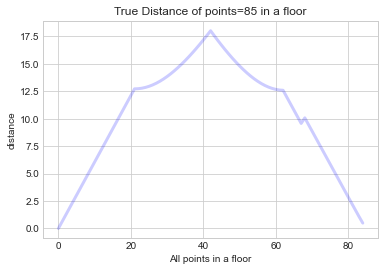

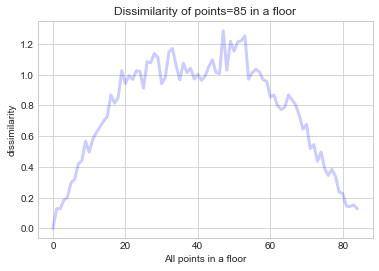

[[0 0 0]
 [0 0 1]
 [1 1 1]
 [0 1 0]
 [0 1 1]]
[[0. 1. 3. 1. 2.]
 [1. 0. 2. 2. 1.]
 [3. 2. 0. 2. 1.]
 [1. 2. 2. 0. 1.]
 [2. 1. 1. 1. 0.]]
[[ 0.9847767   0.84738596]
 [ 0.81047787 -0.37601578]
 [-1.104849   -1.06040621]
 [-0.29311254  0.87364759]
 [-0.39729303 -0.28461157]]


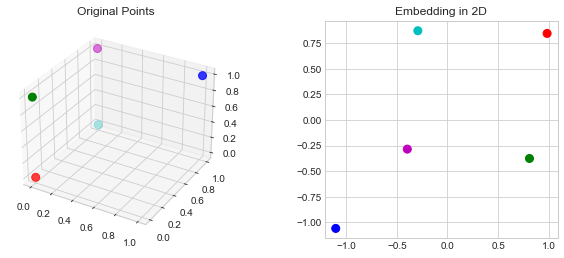

In [151]:
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances


plt.plot(range(0,len(eu_dist_matrix[0])), eu_dist_matrix[0], c = 'b', alpha=0.2, linewidth=3)

#plt.plot([r[2] for r in bd] , [r[3] for r in bd], ".", label='bc', alpha=0.2)
plt.xlabel('All points in a floor')
plt.ylabel('distance')
plt.grid(True)
plt.title(f"True Distance of points={len(etaje[0])} in a floor")
#plt.xticks(range(0, 20, 2))
#plt.ylim(0, 1.0)
#plt.xlim(0, 10.0)
#plt.yticks(np.arange(0, 1, 0.1))
#plt.legend(loc="upper left",shadow=True, fancybox=True)
plt.show()



plt.plot(range(0,len(bc_matrix[0])), bc_matrix[0], c = 'b', alpha=0.2, linewidth=3)

#plt.plot([r[2] for r in bd] , [r[3] for r in bd], ".", label='bc', alpha=0.2)
plt.xlabel('All points in a floor')
plt.ylabel('dissimilarity')
plt.grid(True)
plt.title(f"Dissimilarity of points={len(etaje[0])} in a floor")
#plt.xticks(range(0, 20, 2))
#plt.ylim(0, 1.0)
#plt.xlim(0, 10.0)
#plt.yticks(np.arange(0, 1, 0.1))
#plt.legend(loc="upper left",shadow=True, fancybox=True)
plt.show()





X = np.array([[0, 0, 0], [0, 0, 1], [1, 1, 1], [0, 1, 0], [0, 1, 1]])
dist_manhattan = manhattan_distances(X)
#mds = MDS(dissimilarity='precomputed', random_state=0)
#X_transform_L1 = mds.fit_transform(dist_manhattan)

print(X)
print(dist_manhattan)
print(X_transform_L1)

#print(X)
#print(dist_manhattan)
#print(bc_matrix)

#print(bc_matrix[1])
#print(len(bc_matrix[0]))

colors = ['r', 'g', 'b', 'c', 'm']
size = [64, 64, 64, 64, 64]
fig = plt.figure(2, (10,4))
ax = fig.add_subplot(121, projection='3d')
plt.scatter(X[:,0], X[:,1], zs=X[:,2], s=size, c=colors)
plt.title('Original Points')

ax = fig.add_subplot(122)
plt.scatter(X_transform_L1[:,0], X_transform_L1[:,1], s=size, c=colors)
plt.title('Embedding in 2D')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()


In [149]:
dist_dissim = [[r[2],r[3]] for r in bd]

print(dist_dissim)
mds = MDS(dissimilarity='precomputed', random_state=0)
#X_transform_L1 = mds.fit_transform(dist_dissim)




[[0.6059999999999981, 0.12780214852546073], [1.2109999999999985, 0.1282576459178143], [1.8170000000000002, 0.18189313762709744], [2.4229999999999983, 0.2022388539660013], [3.029, 0.2973792864401849], [3.6340000000000003, 0.31873889166087066], [4.239999999999998, 0.4180162369495018], [4.846, 0.4416976733932533], [5.450999999999997, 0.5681737216893065], [6.056999999999999, 0.49621460763416], [6.663, 0.5803742898856651], [7.268999999999998, 0.6239339467436542], [7.873999999999999, 0.6613865626475992], [8.48, 0.6981000165837024], [9.085999999999999, 0.7274863943981136], [9.690999999999999, 0.8689103653019818], [10.296999999999997, 0.814500044853604], [10.902999999999999, 0.8496147179685963], [11.509, 1.0267341324211423], [12.114, 0.9424275788737615], [12.719999999999995, 0.9942198104586951], [12.734522527366304, 0.9697506254567049], [12.7778959535598, 1.0256399033153294], [12.849969999964976, 1.0217279082563198], [12.950030887994046, 0.9121703535269082], [13.077761429235506, 1.084402555883

In [152]:
dist_dissim = np.array([[r[2],r[3]] for r in bd])

print(len(X),len(X[0]))
print(len(dist_dissim), len(dist_dissim[0]))

mds_dist_dissim = MDS(random_state=0)
#mds_dist_dissim = MDS(dissimilarity='precomputed', random_state=0)
dist_dissim_transform = mds_dist_dissim.fit_transform(dist_dissim.astype(np.float64))






5 3
3570 2


[[-0.82361932 -8.84451106]
 [-0.72361503 -8.24805655]
 [-0.70919561 -7.63840846]
 ...
 [-0.8295833  -8.84419156]
 [-0.81296994 -8.24510439]
 [-0.84114445 -8.84716523]]


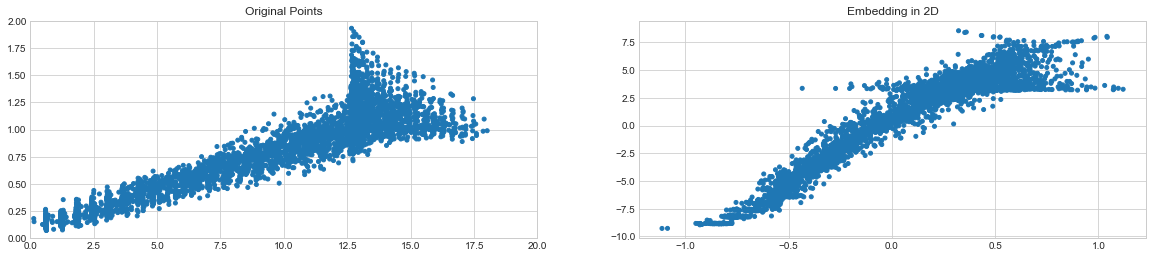

In [183]:
print(dist_dissim_transform)

size = [64] * len(dist_dissim)
fig = plt.figure(2, (20,4))
ax = fig.add_subplot(121)
plt.ylim(0, 2.0)
plt.xlim(0, 20.0)
plt.scatter(dist_dissim[:,0], dist_dissim[:,1], s=size, marker='.')
plt.title('Original Points')

ax = fig.add_subplot(122)
plt.scatter(dist_dissim_transform[:,0], dist_dissim_transform[:,1], s=size, marker = '.')
plt.title('Embedding in 2D')
#fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()




[[-0.19527301 -0.53058651]
 [-0.16264552 -0.4762873 ]
 [-0.30470174 -0.4925365 ]
 [-0.33887678 -0.48678513]
 [-0.37874421 -0.43231391]
 [-0.42435402 -0.42558582]
 [-0.52503678 -0.37425269]
 [-0.50161715 -0.35578753]
 [-0.52659648 -0.30500258]
 [-0.62640233 -0.23991012]
 [-0.59296898 -0.21947072]
 [-0.62470162 -0.13046039]
 [-0.6778119  -0.11116342]
 [-0.70928527 -0.08163858]
 [-0.69051952  0.00603111]
 [-0.75195525 -0.01732328]
 [-0.78999842  0.06712962]
 [-0.71911886  0.08250549]
 [-0.75965924  0.13666702]
 [-0.65994272  0.23459993]
 [-0.57115512  0.22326948]
 [-0.61528094  0.28829934]
 [-0.66838262  0.27599239]
 [-0.5826283   0.33323229]
 [-0.53260271  0.33883544]
 [-0.4587452   0.29413111]
 [-0.5200369   0.40721273]
 [-0.3113693   0.51202969]
 [-0.35389349  0.54312835]
 [-0.25174996  0.53845647]
 [-0.35151996  0.47984777]
 [-0.34660162  0.46588828]
 [-0.17786445  0.57173924]
 [-0.15338898  0.62253679]
 [-0.10985726  0.58477638]
 [ 0.00763097  0.47939164]
 [-0.02965846  0.5620525 ]
 

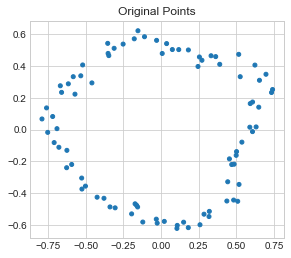

In [186]:
dissim_transform = mds.fit_transform(bc_matrix)

size = [64] * len(dissim_transform)
fig = plt.figure(2, (10,4))
ax = fig.add_subplot(121)
plt.scatter(dissim_transform[:,0], dissim_transform[:,1], s=size, marker = '.')
plt.title('Original Points')

# mark 0, 21, 42, 63, 85
#inspect bray-curtis
#issue: dissim over 1
# MDS cu weight?
# MDS cu distanțe mici
# procrustes (rotație, scalare, translație)


print(dissim_transform)